In [4]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import pandas as pd

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



In [5]:
# 创建SparkSession
spark = SparkSession.builder.appName('Demand Prediction').getOrCreate()

from pyspark.sql.functions import col

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/05 09:58:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# 导入数据

# 1.骨料的情况
data = spark.read.format("csv").option("header", "true").load("data/Aggregate/daily_demand_totals.csv")
# 2.水泥的情况
# data = spark.read.format("csv").option("header", "true").load("data/Concrete/daily_demand_totals.csv")

In [7]:
# Convert the 'demand' column to a numeric type
data = data.withColumn("demand", col("demand").cast("double"))
# 数据清洗和准备
data = data.dropna()
data = data.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))
data = data.withColumn("year", year(col("timestamp")))
data = data.withColumn("month", month(col("timestamp")))
data = data.withColumn("day", dayofmonth(col("timestamp")))

In [8]:
# consider more human common sense
data = data.withColumn("day_of_week", dayofweek(col("timestamp")))
data = data.withColumn("is_weekend", when(col("day_of_week").isin([1, 7]), 1).otherwise(0))


In [9]:
# 特征工程
assembler = VectorAssembler(inputCols=["year", "month", "day", "day_of_week", "is_weekend"], outputCol="features")
data = assembler.transform(data)

In [10]:

# 划分训练和测试数据集
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=100)

# 数据探索

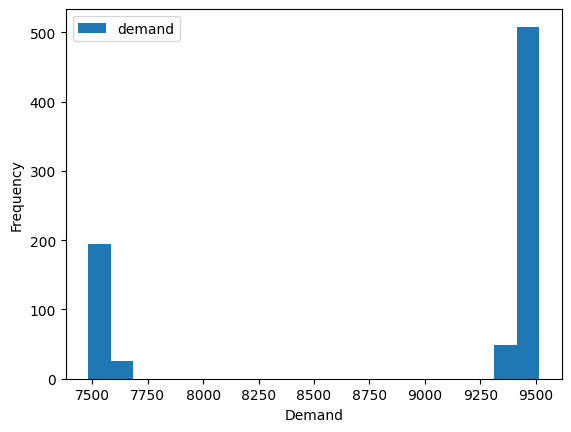

In [11]:
# 绘制demand的直方图
demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='hist', bins=20)
plt.xlabel('Demand')
plt.show()

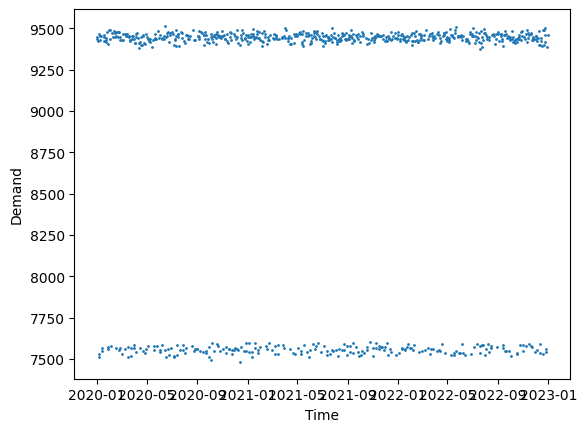

In [12]:
# 绘制demand和时间的散点图
data = train_data.select('timestamp', 'demand').toPandas()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='demand', kind='scatter', s=1)
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

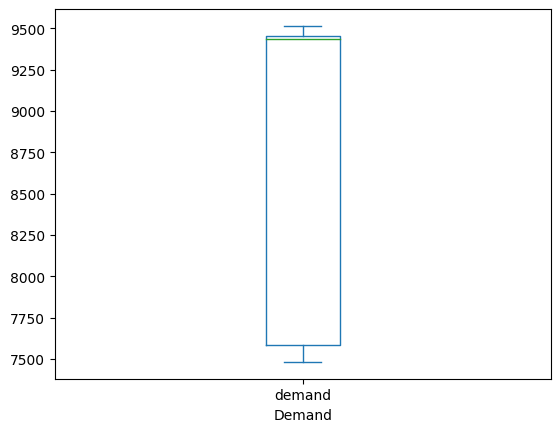

In [30]:
# 用箱线图来检测异常值和数据分布的形状
demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='box')
plt.xlabel('Demand')
plt.show()

In [31]:
# 定义线性回归模型
lr = LinearRegression(featuresCol="features", labelCol="demand")

# 训练模型
lr_model = lr.fit(train_data)

# 预测未来需求
predictions = lr_model.transform(test_data)

# 展示预测结果
predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()



23/04/18 23:14:02 WARN Instrumentation: [1add97be] regParam is zero, which might cause numerical instability and overfitting.
+----+-----+---+-----------+----------+------+------------------+
|year|month|day|day_of_week|is_weekend|demand|        prediction|
+----+-----+---+-----------+----------+------+------------------+
|2020|    1|  4|          7|         1|9454.0|10087.458245667072|
|2020|    1| 11|          7|         1|9420.0|10064.708522858138|
|2020|    1| 12|          1|         1|9447.0| 8870.763891801165|
|2020|    1| 15|          4|         0|9465.0| 8708.866745472274|
|2020|    1| 16|          5|         0|9420.0|  8904.06589684695|
|2020|    1| 20|          2|         0|7573.0| 8295.718719913995|
|2020|    1| 21|          3|         0|7581.0| 8490.917871288668|
|2020|    1| 26|          1|         1|9426.0|   8825.2644461833|
|2020|    1| 30|          5|         0|9446.0| 8858.566451229082|
|2020|    2|  4|          3|         0|7535.0| 8541.189946451537|
|2020|    2|  5|

In [32]:
# 创建随机森林回归模型
rf = RandomForestRegressor(featuresCol="features", labelCol="demand", numTrees=10)

# 训练模型
rf_model = rf.fit(train_data)

# 预测未来需求
predictions = rf_model.transform(test_data)

# 计算模型的评估指标（均方误差）
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# 展示预测结果
predictions.select("year", "month", "day", "demand", "prediction").show()

# 输出均方误差
print("Mean Squared Error (MSE) on test data = %g" % mse)


+----+-----+---+------+------------------+
|year|month|day|demand|        prediction|
+----+-----+---+------+------------------+
|2020|    1|  4|9454.0| 9443.933660895556|
|2020|    1| 11|9420.0| 9442.449921531263|
|2020|    1| 12|9447.0| 9451.518572270732|
|2020|    1| 15|9465.0| 9381.865081989354|
|2020|    1| 16|9420.0| 9382.785297565872|
|2020|    1| 20|7573.0| 7687.300452161522|
|2020|    1| 21|7581.0| 7685.655713941325|
|2020|    1| 26|9426.0| 9450.553573934838|
|2020|    1| 30|9446.0| 9385.035631362774|
|2020|    2|  4|7535.0|7678.9933765123205|
|2020|    2|  5|9425.0|  9377.34688670035|
|2020|    2|  7|9446.0| 9347.680382949064|
|2020|    2|  8|9463.0| 9443.154947986288|
|2020|    2| 10|7597.0| 7834.132756372912|
|2020|    2| 11|7545.0| 7677.415655266561|
|2020|    2| 18|7569.0| 7683.572637018248|
|2020|    2| 22|9448.0| 9444.874771501807|
|2020|    2| 28|9461.0| 9385.035631362774|
|2020|    2| 29|9431.0| 9445.505196718785|
|2020|    3|  3|7547.0| 7648.956088934987|
+----+-----

In [33]:
# 创建梯度提升树回归模型
gbt = GBTRegressor(featuresCol="features", labelCol="demand", maxIter=10)

# 训练模型
gbt_model = gbt.fit(train_data)

# 预测未来需求
predictions = gbt_model.transform(test_data)

# 计算模型的评估指标（均方误差）
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# 展示预测结果
predictions.select("year", "month", "day", "demand", "prediction").show()

# 输出均方误差
print(" 3 Mean Squared Error (MSE) on test data = %g" % mse)

+----+-----+---+------+-----------------+
|year|month|day|demand|       prediction|
+----+-----+---+------+-----------------+
|2020|    1|  4|9454.0|9451.535132010034|
|2020|    1| 11|9420.0| 9465.03487660728|
|2020|    1| 12|9447.0|9435.635496037023|
|2020|    1| 15|9465.0|9463.241857995656|
|2020|    1| 16|9420.0|9454.673274596578|
|2020|    1| 20|7573.0|7557.852397988255|
|2020|    1| 21|7581.0|7559.108337341195|
|2020|    1| 26|9426.0|  9444.7290418998|
|2020|    1| 30|9446.0|9441.272686670985|
|2020|    2|  4|7535.0|7561.709267554762|
|2020|    2|  5|9425.0|9443.881852761118|
|2020|    2|  7|9446.0|9435.494182912302|
|2020|    2|  8|9463.0|9456.766487800061|
|2020|    2| 10|7597.0| 7548.97646628354|
|2020|    2| 11|7545.0|7548.861412724012|
|2020|    2| 18|7569.0|7564.772614029863|
|2020|    2| 22|9448.0| 9445.20137893441|
|2020|    2| 28|9461.0|9445.104606596418|
|2020|    2| 29|9431.0|9448.321223937632|
|2020|    3|  3|7547.0|7545.427264310072|
+----+-----+---+------+-----------

In [34]:
print('#'*20)
import matplotlib.pyplot as plt

# 使用三种不同的模型进行预测
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# 使用均方误差评估每个模型的预测效果
lr_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
lr_mse = lr_evaluator.evaluate(lr_predictions)
rf_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
rf_mse = rf_evaluator.evaluate(rf_predictions)
gbt_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
gbt_mse = gbt_evaluator.evaluate(gbt_predictions)



####################


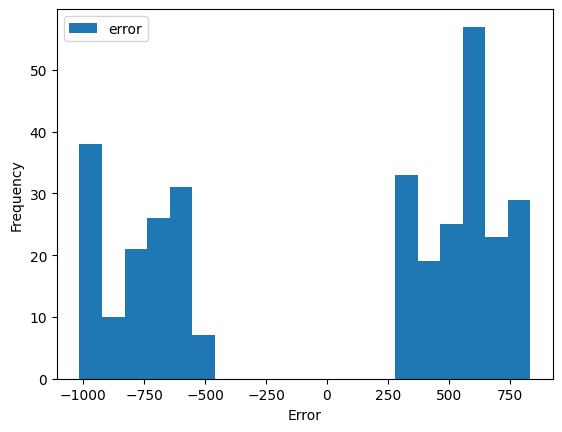

In [35]:
# 选取 lr_model作为例子 预测误差分布图来观察模型的预测误差是否符合正态分布
# 计算预测误差
lr_predictions = lr_model.transform(test_data)
lr_errors = lr_predictions.select("demand", "prediction").rdd.map(lambda x: x[0] - x[1]).collect()

# 绘制预测误差分布图
pd.DataFrame(lr_errors, columns=['error']).plot(kind='hist', bins=20)
plt.xlabel('Error')
plt.show()

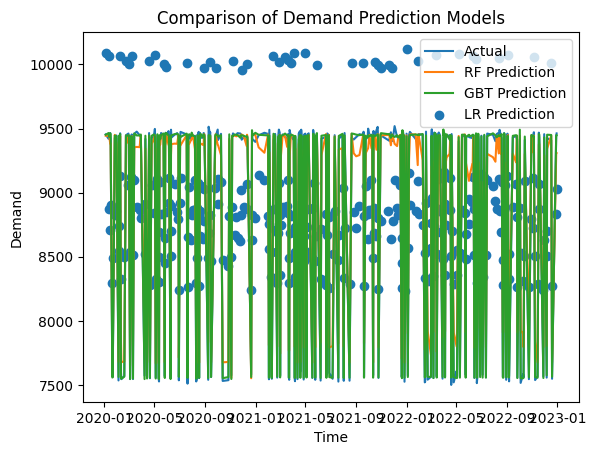

Linear Regression Mean Squared Error (MSE) on test data = 455801
Random Forest Mean Squared Error (MSE) on test data = 26554.7
Gradient Boosting Tree Mean Squared Error (MSE) on test data = 651.349


In [36]:
# 创建一个时间序列的数组
time_series = test_data.select("timestamp").rdd.flatMap(lambda x: x).collect()

# Create a matplotlib chart and plot the actual demand and predictions from each model
fig, ax = plt.subplots()
ax.plot(time_series, test_data.select("demand").collect(), label="Actual")
ax.plot(time_series, rf_predictions.select("prediction").collect(), label="RF Prediction")
ax.plot(time_series, gbt_predictions.select("prediction").collect(), label="GBT Prediction")
ax.scatter(time_series, lr_predictions.select("prediction").collect(), label="LR Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Comparison of Demand Prediction Models")
ax.legend()

# Show the chart
plt.show()


# 输出评估结果
print("Linear Regression Mean Squared Error (MSE) on test data = %g" % lr_mse)
print("Random Forest Mean Squared Error (MSE) on test data = %g" % rf_mse)
print("Gradient Boosting Tree Mean Squared Error (MSE) on test data = %g" % gbt_mse)


In [37]:
print('在预测结果可视化图表中，随机森林(Random Forest)模型和梯度提升树(Gradient Boosting Tree)\
模型的预测结果比线性回归(Linear Regression)模型的预测结果更接近实际需求值，\
选择均方误差最小的模型，也就是梯度提升树模型，作为最终的库存预测模型')

在预测结果可视化图表中，随机森林(Random Forest)模型和梯度提升树(Gradient Boosting Tree)模型的预测结果比线性回归(Linear Regression)模型的预测结果更接近实际需求值，选择均方误差最小的模型，也就是梯度提升树模型，作为最终的库存预测模型


In [38]:
import calendar
from datetime import datetime

# 生成2023年的特征数据
features_2023 = []
for month in range(1, 13):
    for day in range(1, calendar.monthrange(2023, month)[1] + 1):
        day_of_week = datetime(2023, month, day).weekday()
        is_weekend = 1 if day_of_week in (5, 6) else 0
        features_2023.append((2023, month, day, day_of_week, is_weekend))




In [39]:
# 将特征数据转换为DataFrame
features_2023_df = spark.createDataFrame(features_2023, ["year", "month", "day", "day_of_week", "is_weekend"])

# 使用特征工程生成特征向量
features_2023_df = assembler.transform(features_2023_df)

# 使用梯度提升树模型进行预测
predictions_2023 = gbt_model.transform(features_2023_df)

# 将预测结果转换为Pandas DataFrame
predictions_2023_df = predictions_2023.select("year", "month", "day", "prediction").toPandas()
predictions_2023_df['timestamp'] = pd.to_datetime(predictions_2023_df[['year', 'month', 'day']])

# 保留2位小数
predictions_2023_df['prediction'] = predictions_2023_df['prediction'].round(2)

# 保存预测结果到CSV文件
# 骨料保存1
predictions_2023_df.to_csv("data/Aggregate/predictions_2023.csv", index=False)
# 水泥保存2
# predictions_2023_df.to_csv("data/Concrete/predictions_2023.csv", index=False)